In [3]:
#!/grid/gillis/home/nfox/software/miniconda3/bin/python
import h5py

import numpy as np

import scipy.sparse as ss
import pandas as pd
import argparse
import os
import shutil
import numpy as np
import pandas as pd
import scipy.spatial.distance as ssd
from scipy import sparse
import numpy as np
import scipy.stats as stats
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler

INFO:numexpr.utils:Note: detected 192 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 192 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [1]:
jac_sim_path='/grid/gillis/data/lohia/hi_c_data_processing/data_human/SRP168606/40kbp_raw/compartment/KR_pca1_gw.h5'

In [4]:
jac_sim = hm.hiCMatrix(jac_sim_path)

In [8]:
jac_sim.matrix.toarray()

array([[0, 1, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0]])

In [20]:
exp_file_path='/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/human_prioAggNet.h5'
exp_sim = hm.hiCMatrix(exp_file_path)
exp_genes = [x[3].decode() for x in exp_sim.cut_intervals]
df = df[df['gene'].isin(exp_genes)]

In [33]:
len(exp_genes)

24243

In [34]:
len(list(set(exp_genes)))

24243

In [10]:
gl = [x[3].decode() for x in jac_sim.cut_intervals]

In [21]:
    input_file = f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/SRP168606/40kbp_raw/compartment/chr3_intra_KR_pca1_genes.bed'
    df = pd.read_csv(f'{input_file}', sep='\t', usecols=[0,3,9], names=['chrom', 'gene', 'pca1'])
    
    

In [27]:
['True' if x in exp_genes else 'False' for x in df['gene'].tolist()]

['False',
 'False',
 'True',
 'False',
 'False',
 'False',
 'False',
 'True',
 'False',
 'False',
 'False',
 'False',
 'True',
 'False',
 'False',
 'False',
 'False',
 'False',
 'False',
 'True',
 'False',
 'False',
 'False',
 'False',
 'False',
 'True',
 'True',
 'True',
 'True',
 'False',
 'True',
 'True',
 'True',
 'False',
 'True',
 'True',
 'True',
 'False',
 'True',
 'True',
 'True',
 'True',
 'False',
 'False',
 'False',
 'False',
 'True',
 'True',
 'True',
 'False',
 'False',
 'False',
 'False',
 'False',
 'False',
 'False',
 'False',
 'False',
 'True',
 'False',
 'False',
 'False',
 'False',
 'False',
 'False',
 'False',
 'False',
 'True',
 'False',
 'True',
 'False',
 'True',
 'True',
 'True',
 'False',
 'False',
 'True',
 'False',
 'True',
 'True',
 'False',
 'False',
 'True',
 'True',
 'False',
 'True',
 'True',
 'True',
 'False',
 'True',
 'True',
 'True',
 'True',
 'True',
 'True',
 'True',
 'False',
 'True',
 'False',
 'True',
 'True',
 'True',
 'True',
 'True',
 'False'

In [31]:
df['gene'].isin(exp_genes)[0:10]

0    False
1    False
2     True
3    False
4    False
5    False
6    False
7     True
8    False
9    False
Name: gene, dtype: bool

In [32]:
df[df['gene'].isin(exp_genes)]

chrom             gene      pca1
2     chr3  ENSG00000134121 -0.018689
7     chr3  ENSG00000224957 -0.020807
12    chr3  ENSG00000134115 -0.017348
19    chr3  ENSG00000144619 -0.016747
25    chr3  ENSG00000091181 -0.008642
...    ...              ...       ...
3015  chr3  ENSG00000234742  0.024699
3017  chr3  ENSG00000182899  0.022783
3018  chr3  ENSG00000114473  0.021425
3019  chr3  ENSG00000185621  0.021425
3027  chr3  ENSG00000236438  0.003877

[1381 rows x 3 columns]

In [12]:
len(gl)

55412

In [13]:
len(list(set(gl)))

55411

In [18]:
import collections
counter=collections.Counter(gl)

In [19]:
(counter.most_common(3))

[('ENSG00000134020', 2), ('ENSG00000223972', 1), ('ENSG00000278267', 1)]

In [1]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=20, max_count=5000):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns), go

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P

In [3]:
        species = 'human'
        df = pd.read_csv(f'/sonas-hs/gillis/hpc/data/lohia/hi_c_data_processing/software/CoCoCoNet/gene2go/{species}_gene2go.csv', delim_whitespace=True)




        df['val'] = 1

        go_table = pd.pivot_table(df, index=['NetworkIDs'],columns=['GO_term'])


        go_table = go_table.fillna(0)

        go_table = pd.DataFrame(go_table.values ,  index=go_table.index , columns = [x[1] for x in go_table.columns])

        from hicmatrix import HiCMatrix as hm
        from hicmatrix.lib import MatrixFileHandler


        exp_file_path = '/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/human_dist.h5'
        exp_file = hm.hiCMatrix(exp_file_path)
        chr_list_1 = exp_file.getChrNames()
        exp_genes_all = [x[3].decode() for x in exp_file.cut_intervals]
        exp_matrix = exp_file.matrix.toarray()
    



        exp_matrix = 1/ exp_matrix



        np.fill_diagonal(exp_matrix , 0)




        from numpy import inf
        exp_matrix[exp_matrix == inf] = 0

        df_exp = pd.DataFrame(exp_matrix ,  index=exp_genes_all , columns = exp_genes_all)
        

NameError: name 'a' is not defined

In [30]:
df = pd.read_csv("/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/human.bed", sep='\t' , names=['l', 'a', 'b', 'c', 'd', 'e'])

In [46]:
df['txStart_outer'] = [x if z=='+' else y for x,y,z in zip(df['a'] , df['b'] , df['e'] )]

In [49]:
list(zip(['a', 'b'],['c', 'd'] ))

[('a', 'c'), ('b', 'd')]

In [2]:
import gc

In [67]:
import argparse
import os
import shutil
import numpy as np
import pandas as pd
import scipy.spatial.distance as ssd
from scipy import sparse
import numpy as np
import scipy.stats as stats
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler




def make_distance_matrix(gene_folder, dist_folder, chr_list):


    gene_file = pd.read_csv(gene_folder, sep='\t', names=['chrom', 'start', 'end', '#geneId', 'extra', 'strand'])
    gene_file['txStart_outer'] = [x if z=='+' else y for x,y,z in zip(gene_file['start'] , gene_file['end'] , gene_file['strand'] )]
    gene_file['txEnd_outer'] = [y if z=='+' else x for x,y,z in zip(gene_file['start'] , gene_file['end'] , gene_file['strand'] )]
    gr = gene_file.groupby('chrom')
    
    matrix_list = []
    interval_list = []
    chr_interval_list = []
    tss_start_list = []
    tss_end_list = []
    
    for chrom in chr_list:
        gene_data = gr.get_group(chrom)
        interval_list.extend(gene_data['#geneId'].tolist())
        chr_interval_list.extend([chrom for x in gene_data['#geneId'].tolist()])
        tss_start_list.extend(gene_data['txStart_outer'].tolist())
        tss_end_list.extend(gene_data['txEnd_outer'].tolist())
        
        
        dist_mat = ssd.squareform(
                 ssd.pdist(
                   np.reshape(
                     np.array(gene_data['txStart_outer']),
                     (gene_data.shape[0], 1)
                   )
                 )
               )
        print (dist_mat.max())
        matrix_list.append(sparse.coo_matrix(dist_mat))
    matrix_genome_wide = sparse.block_diag(matrix_list)
    #print (matrix_genome_wide)
    
    cut_intervals_list = list(zip(chr_interval_list, [0 for i in interval_list], [1 for i in interval_list], interval_list))
    #print (cut_intervals_list)
    
    #initialize hic object again for saving
    hic = hm.hiCMatrix()
    hic.nan_bins = []
    # make matrix symmetric
    hic.setMatrix(matrix_genome_wide, cut_intervals_list)
    #hic.fillLowerTriangle()
    #hic.save(dist_folder)

In [68]:
    genome_dir = '/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/'
    #chr_list = ['chr' + str(x) for x in list(range(1,23))]
    #make_distance_matrix(f'{genome_dir}/human.bed', f'{genome_dir}/human_dist.h5', chr_list)
    
    
    
    chr_list=["chr3R"]
    make_distance_matrix(f'{genome_dir}/drosophila.bed', f'{genome_dir}/drosophila_dist.h5', chr_list)

31501366.0


In [8]:
df_unique_variants_sig = pd.read_csv(f"/grid/gillis/data/lohia/eQTL/GTEx_Analysis_v8_eQTL_all_associations/combines.allpairs.txt.gz", sep='\t')



MemoryError: Unable to allocate 66.2 GiB for an array with shape (8879509611,) and data type object

In [ ]:
df_unique_variants_sig.drop_duplicates(inplace=True)

In [71]:
given_tissue="Whole_Blood"

In [72]:
df_unique_AV= pd.read_csv(f"/grid/gillis/data/lohia/eQTL/GTEx_Analysis_v8_eQTL_all_associations/Adipose_Visceral_Omentum.allpairs.txt.gz", sep='\t')

        

In [73]:
df_unique_AS= pd.read_csv(f"/grid/gillis/data/lohia/eQTL/GTEx_Analysis_v8_eQTL_all_associations/Adipose_Subcutaneous.allpairs.txt.gz", sep='\t')


In [75]:
df_unique_AV.shape

(181695704, 9)

In [76]:
df_unique_AS.drop_duplicates(subset=['gene_id', 'variant_id'])

(181271376, 9)

In [77]:
df_unique_AV

gene_id              variant_id  tss_distance  \
0           ENSG00000227232.5      chr1_13550_G_A_b38        -16003   
1           ENSG00000227232.5      chr1_14671_G_C_b38        -14882   
2           ENSG00000227232.5      chr1_14677_G_A_b38        -14876   
3           ENSG00000227232.5      chr1_16841_G_T_b38        -12712   
4           ENSG00000227232.5      chr1_16856_A_G_b38        -12697   
...                       ...                     ...           ...   
181695699  ENSG00000182484.15  chrX_156025186_G_C_b38          4360   
181695700  ENSG00000182484.15  chrX_156025429_T_C_b38          4603   
181695701  ENSG00000182484.15  chrX_156025583_C_T_b38          4757   
181695702  ENSG00000182484.15  chrX_156029674_G_A_b38          8848   
181695703  ENSG00000182484.15  chrX_156029823_G_A_b38          8997   

           ma_samples  ma_count       maf  pval_nominal     slope  slope_se  
0                  11        11  0.011727      0.012080  0.553305  0.219451  
1                  11        11  0.011727      0.860988 -0.039321  0.224399  
2                  49        49  0.052239      0.255810 -0.125770  0.110520  
3                  38        38  0.040512      0.502830 -0.081397  0.121370  
4                   8         8  0.008529      0.474407 -0.180559  0.252176  
...               ...       ...       ...           ...       ...       ...  
181695699          11        11  0.011727      0.213574  0.339681  0.272664  
181695700         135       138  0.147122      0.852241 -0.016152  0.086662  
181695701         114       117  0.124733      0.051183 -0.180945  0.092516  
181695702          10        10  0.010661      0.094240  0.455470  0.271527  
181695703          13        13  0.013859      0.851280  0.045450  0.242262  

[181695704 rows x 9 columns]

In [78]:
df_unique_AS

gene_id              variant_id  tss_distance  \
0           ENSG00000227232.5      chr1_13550_G_A_b38        -16003   
1           ENSG00000227232.5      chr1_14671_G_C_b38        -14882   
2           ENSG00000227232.5      chr1_14677_G_A_b38        -14876   
3           ENSG00000227232.5      chr1_16841_G_T_b38        -12712   
4           ENSG00000227232.5      chr1_16856_A_G_b38        -12697   
...                       ...                     ...           ...   
181271371  ENSG00000182484.15  chrX_156025186_G_C_b38          4360   
181271372  ENSG00000182484.15  chrX_156025429_T_C_b38          4603   
181271373  ENSG00000182484.15  chrX_156025583_C_T_b38          4757   
181271374  ENSG00000182484.15  chrX_156029674_G_A_b38          8848   
181271375  ENSG00000182484.15  chrX_156029823_G_A_b38          8997   

           ma_samples  ma_count       maf  pval_nominal     slope  slope_se  
0                  18        18  0.015491      0.227454  0.243701  0.201673  
1                  12        12  0.010327      0.090710  0.419844  0.247715  
2                  60        60  0.051635      0.290965 -0.120766  0.114243  
3                  50        50  0.043029      0.523798 -0.078482  0.123024  
4                  13        13  0.011188      0.338762 -0.224404  0.234362  
...               ...       ...       ...           ...       ...       ...  
181271371          15        15  0.012909      0.187140  0.329588  0.249526  
181271372         157       161  0.138554      0.267734 -0.098321  0.088617  
181271373         141       144  0.123924      0.555089 -0.054189  0.091761  
181271374          10        10  0.008606      0.254213  0.352740  0.309025  
181271375          23        23  0.019793      0.770009 -0.060058  0.205314  

[181271376 rows x 9 columns]

In [15]:
    df_list_non_sig = []
    tissue_all_pairs_name = pd.read_csv('/grid/gillis/data/lohia/eQTL/GTEx_Analysis_v8_eQTL_all_associations/tissue.txt', names=['tissue'])
    tissue_all_pairs_name['tissue'] = [x.split('.')[0] for x in tissue_all_pairs_name['tissue']]
    for tissue_name in tissue_all_pairs_name['tissue'] :
        #print (tissue_name)
        if tissue_name == given_tissue:
            df_unique_variants_sig = pd.read_csv(f"/grid/gillis/data/lohia/eQTL/GTEx_Analysis_v8_eQTL_all_associations/{tissue_name}.allpairs.txt.gz", sep='\t')
            df_unique_variants_sig['prediction'] = 0
            df_list_non_sig.append(df_unique_variants_sig)

        

In [ ]:
    tissue_all_pairs_name = pd.read_csv('/grid/gillis/data/lohia/eQTL/GTEx_Analysis_v8_eQTL_all_associations/tissue.txt', names=['tissue'])
    tissue_all_pairs_name['tissue'] = [x.split('.')[0] for x in tissue_all_pairs_name['tissue']]
    for tissue_name in tissue_all_pairs_name['tissue'] :
        #print (tissue_name)
        if tissue_name != given_tissue:
            df_unique_variants_sig = pd.read_csv(f"/grid/gillis/data/lohia/eQTL/GTEx_Analysis_v8_eQTL_all_associations/{tissue_name}.allpairs.txt.gz", sep='\t')
            df_unique_variants_sig['prediction'] = 0
            df_unique_variants_sig = pd.concat([df_list_non_sig[0], df_unique_variants_sig])
            df_unique_variants_sig = df_unique_variants_sig.drop_duplicates()
            print (df_unique_variants_sig.shape)
            df_list_non_sig = []
            df_list_non_sig.append(df_unique_variants_sig)
            print (tissue_name)

Adipose_Subcutaneous
Adipose_Visceral_Omentum
Adrenal_Gland
Artery_Aorta
Artery_Coronary
Artery_Tibial
Brain_Amygdala
Brain_Anterior_cingulate_cortex_BA24
Brain_Caudate_basal_ganglia


In [103]:
df_unique_variants_not_sig = pd.concat(df_list_non_sig)

In [ ]:
df_unique_variants_not_sig.head()

In [ ]:
df_unique_variants_not_sig.drop_duplicates(inplace=True)

In [3]:
    df_list = []
    tissue_all_pairs_name = pd.read_csv('/grid/gillis/data/lohia/eQTL/GTEx_Analysis_v8_eQTL_all_associations/tissue.txt', names=['tissue'])
    tissue_all_pairs_name['tissue'] = [x.split('.')[0] for x in tissue_all_pairs_name['tissue']]
    for tissue_name in tissue_all_pairs_name['tissue'] :
        #print (tissue_name)
        #if tissue_name == given_tissue:
        df_unique_variants_sig = pd.read_csv(f"/grid/gillis/data/lohia/eQTL/GTEx_Analysis_v8_eQTL/{tissue_name}.v8.signif_variant_gene_pairs.txt.gz", sep='\t')
        df_unique_variants_sig['prediction'] = 1
        df_list.append(df_unique_variants_sig)

        

In [21]:
pd.read_csv(f"/grid/gillis/data/lohia/eQTL/GTEx_Analysis_v8_eQTL/{tissue_name}.v8.signif_variant_gene_pairs.txt.gz", sep='\t')

variant_id             gene_id  tss_distance  ma_samples  \
0            chr1_64764_C_T_b38   ENSG00000227232.5         35211          79   
1           chr1_665098_G_A_b38   ENSG00000227232.5        635545         140   
2           chr1_666028_G_A_b38   ENSG00000227232.5        636475         125   
3            chr1_17556_C_T_b38   ENSG00000238009.6       -111667          27   
4            chr1_58814_G_A_b38   ENSG00000238009.6        -70409         109   
...                         ...                 ...           ...         ...   
2414648  chrX_155999818_C_T_b38  ENSG00000182484.15        -21008         419   
2414649  chrX_155999957_G_C_b38  ENSG00000182484.15        -20869         403   
2414650  chrX_156000131_G_A_b38  ENSG00000182484.15        -20695         402   
2414651  chrX_156001267_A_G_b38  ENSG00000182484.15        -19559         400   
2414652  chrX_156003433_T_C_b38  ENSG00000182484.15        -17393         421   

         ma_count       maf  pval_nominal     slope  slope_se  \
0              80  0.059701  1.727560e-09  0.516614  0.084465   
1             146  0.108955  8.848980e-13  0.462697  0.063337   
2             131  0.097761  3.851330e-13  0.489662  0.065936   
3              27  0.020149  1.485310e-06  0.760661  0.156447   
4             119  0.088806  1.494340e-18  0.636831  0.070098   
...           ...       ...           ...       ...       ...   
2414648       515  0.384328  2.348120e-04  0.181808  0.049128   
2414649       487  0.363433  1.555250e-04  0.181509  0.047686   
2414650       485  0.361940  1.613730e-04  0.180934  0.047652   
2414651       481  0.358955  2.384740e-04  0.176194  0.047663   
2414652       532  0.397015  2.289130e-04  0.182167  0.049138   

         pval_nominal_threshold  min_pval_nominal     pval_beta  
0                      0.000393      3.851330e-13  1.052580e-09  
1                      0.000393      3.851330e-13  1.052580e-09  
2                      0.000393      3.851330e-13  1.052580e-09  
3                      0.000333      4.994340e-31  1.059730e-25  
4                      0.000333      4.994340e-31  1.059730e-25  
...                         ...               ...           ...  
2414648                0.000667      9.487160e-05  5.026270e-02  
2414649                0.000667      9.487160e-05  5.026270e-02  
2414650                0.000667      9.487160e-05  5.026270e-02  
2414651                0.000667      9.487160e-05  5.026270e-02  
2414652                0.000667      9.487160e-05  5.026270e-02  

[2414653 rows x 12 columns]

In [4]:
df_unique_variants_sig = pd.concat(df_list)

In [5]:
df_tissue_varinats = df_unique_variants_sig.groupby(['variant_id', 'gene_id', 'tss_distance'])['prediction'].sum().reset_index()



In [70]:
df_tissue_varinats.to_csv('/grid/gillis/data/lohia/eQTL/GTEx_Analysis_v8_eQTL/all_association_del.csv.gz', index=False, sep='\t', compression='gzip')


In [11]:
df_tissue_varinats['tss_distance'] = df_tissue_varinats['tss_distance'].abs()

In [ ]:
arabidopsis_prioAggNet.hdf5                                            
boar_prioAggNet.hdf5                                                   
chicken_prioAggNet.hdf5                                                
cow_prioAggNet.hdf5                                                    
fruitfly_prioAggNet.hdf5                                               
human_prioAggNet.hdf5                                                  
maize_prioAggNet.hdf5                                                  
mouse_prioAggNet.hdf5                                                  
rat_prioAggNet.hdf5                                                    
rice_prioAggNet.hdf5                                                   
roundworm_prioAggNet.hdf5                                              
soybean_prioAggNet.hdf5                                                
yeast_prioAggNet.hdf5                                                  
zebrafish_prioAggNet.hdf5 

(array([10597991.,  1303602.,   615821.,   395051.,   225533.,   205835.,
          146436.,   106106.,    87756.,   107778.]),
 array([ 1. ,  5.8, 10.6, 15.4, 20.2, 25. , 29.8, 34.6, 39.4, 44.2, 49. ]),
 <BarContainer object of 10 artists>)

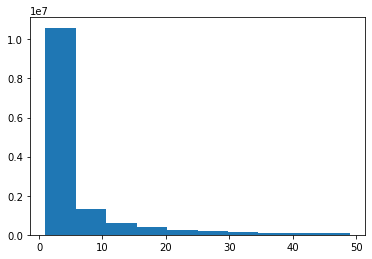

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(df_tissue_varinats['prediction'])

(array([550238., 182930.,  80451.,  44192.,  27290.,  21362.,  15169.,
          9609.,   7831.,   5614.]),
 array([     0. ,  99999.7, 199999.4, 299999.1, 399998.8, 499998.5,
        599998.2, 699997.9, 799997.6, 899997.3, 999997. ]),
 <BarContainer object of 10 artists>)

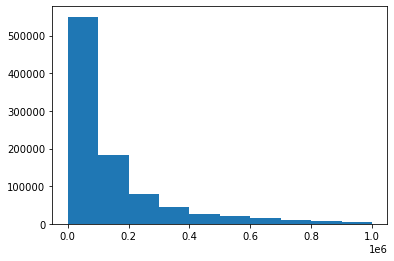

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(df_tissue_varinats[df_tissue_varinats['prediction']  >= 20]['tss_distance'])

(array([5605199., 2625074., 1460813.,  907313.,  629082.,  470007.,
         384891.,  313825.,  273601.,  242660.]),
 array([      0.,  100000.,  200000.,  300000.,  400000.,  500000.,
         600000.,  700000.,  800000.,  900000., 1000000.]),
 <BarContainer object of 10 artists>)

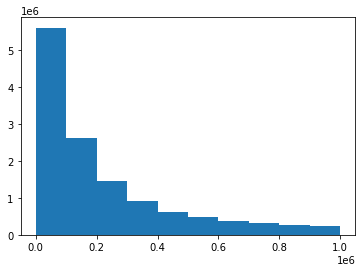

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(df_tissue_varinats[df_tissue_varinats['prediction']  <= 20]['tss_distance'])

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot( df_tissue_varinats['tss_distance'], df_tissue_varinats['prediction'], )

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7ffb0cf6a790> (for post_execute):


OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)

OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)

<Figure size 432x288 with 1 Axes>

In [22]:
df_tissue_varinats[df_tissue_varinats['prediction']  >= 10]

variant_id             gene_id  tss_distance  \
1         chr10_100000235_C_T_b38  ENSG00000095485.16        267445   
2         chr10_100000235_C_T_b38  ENSG00000107554.16          9684   
15        chr10_100002628_A_C_b38  ENSG00000095485.16        265052   
16        chr10_100002628_A_C_b38  ENSG00000107554.16          7291   
24        chr10_100004827_A_C_b38  ENSG00000095485.16        262853   
...                           ...                 ...           ...   
13791872      chrX_998073_C_T_b38   ENSG00000237531.6          7852   
13791881      chrX_998394_A_G_b38   ENSG00000237531.6          8173   
13791882      chrX_998404_A_G_b38   ENSG00000237531.6          8183   
13791893      chrX_998890_G_A_b38   ENSG00000237531.6          8669   
13791907      chrX_999905_T_C_b38   ENSG00000237531.6          9684   

          prediction  
1                 18  
2                 18  
15                18  
16                19  
24                16  
...              ...  
13791872          18  
13791881          12  
13791882          12  
13791893          12  
13791907          11  

[2066276 rows x 4 columns]

In [23]:
import h5py
import numpy as np
import scipy.sparse as ss
import pandas as pd

def get_chrom_sizes(chroms):
    chrom_sizes = {}
    with open(chroms, 'r') as f:
        for line in f:
            values = line.split('\t')
            chrom_sizes[values[0]] = int(values[1])
    return(chrom_sizes)



def generate_regions_bed_file(interval, chr_list, chrom_size_path):
    assert(type(interval) == int)
    print (chr_list)
    temp = get_chrom_sizes(chrom_size_path)
    size_lookup = {c: temp[c] for c in chr_list}
    # build each chroms dataframe and append to list
    chrom_regions = []
    for c, size in size_lookup.items():
        start = np.arange(0, size, interval)
        end = np.arange(interval, size, interval)
        print (size)
        
        end = np.append(end,size)
        
        chrom_regions.append((pd.DataFrame({'chrom': c,
                                            'start': start,
                                            'end': end})))
    # concat dataframes
    return(pd.concat(chrom_regions, ignore_index=True))



df_regions_bed = generate_regions_bed_file(100000, ['chr3', 'chr4'], '/grid/gillis/data/nfox/genomes/homo_sapiens_38/hg38.chrom.sizes')

In [24]:
df_regions_bed = generate_regions_bed_file(100000, ['chr3', 'chr4'], '/grid/gillis/data/nfox/genomes/homo_sapiens_38/hg38.chrom.sizes')

['chr3', 'chr4']
198295559
190214555


In [30]:
df = pd.read_csv('/grid/gillis/data/nfox/hi_c_data_processing/data_human/stats/project_network_counts.txt', sep=" ", names=['p', 'c'])

In [34]:
df['c'].sum()

3621

In [47]:
df = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/stats/human_exclude_count_intra.txt', sep="\t")



In [60]:
df = df.drop_duplicates(subset=['run_id'])

In [61]:
run_id = []
for i in range(1658570, 1658603+1):
    run_id.append(f'SRR{i}')


In [67]:
df = df[df['run_id'].isin(run_id)]

In [70]:
df.to_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/stats/rao_GSE63525_GM12878_combined', index=False, sep= '\t')



In [57]:
df

proj_id      srx_id       run_id  counts_intra  chrom
0      SRP105082  SRX4063543   SRR7143261         35859   chr1
1      SRP105082  SRX4063543   SRR7143261         37134   chr2
2      SRP105082  SRX4063543   SRR7143261         29405   chr3
3      SRP105082  SRX4063543   SRR7143261         25793   chr4
4      SRP105082  SRX4063543   SRR7143261         25135   chr5
...          ...         ...          ...           ...    ...
79285  SRP071243  SRX8330501  SRR11777634       3375204  chr18
79286  SRP071243  SRX8330501  SRR11777634       2377432  chr19
79287  SRP071243  SRX8330501  SRR11777634       2751171  chr20
79288  SRP071243  SRX8330501  SRR11777634       1377300  chr21
79289  SRP071243  SRX8330501  SRR11777634       1339707  chr22

[79290 rows x 5 columns]

In [15]:
print (end)

NameError: name 'end' is not defined

In [466]:
chrom_list=["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10","chr11","chr12","chr13","chr14","chr15","chr16","chr17","chr18","chr19","chr20","chr21","chr22"]

chrom_list=["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10","chr11","chr12","chr13","chr14","chr15","chr16","chr17","chr18","chr19"]

chrom_list = ["chr3R","chr3L","chr2R","chr2L","chr4"]

In [467]:
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
    
df = pd.read_csv('/grid/gillis/data/nfox/hi_c_data_processing/data_mouse/stats/project_network_counts.txt', sep=' ', names=['id', 'contacts'])
counts_list_intra = []
counts_list_inter = []
chrom_name = []
proj_id = []
for proj in df['id']:
    for chrom in chrom_list:
        input_file = (f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/{proj}/250kbp_raw/{chrom}_intra_none.h5')
        hic = hm.hiCMatrix(input_file)
        counts_list_intra.append(hic.matrix.sum())
        chrom_name.append(chrom)
        proj_id.append(proj)
        #input_file = (f'/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/{proj}/10kbp_raw/inter_KR.h5')
        #print (path.exists(input_file))
        #hic = hm.hiCMatrix(input_file)
        #counts_list_inter.append(hic.matrix.sum())

    


In [468]:
df = pd.DataFrame({'id': proj_id, 'counts_intra': counts_list_intra, 'chrom':  chrom_name})
df.to_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/stats/mouse_project_contacts_count.txt', index=False, sep='\t')

In [469]:
d2 = df.groupby(['id'])['counts_intra'].sum().reset_index()

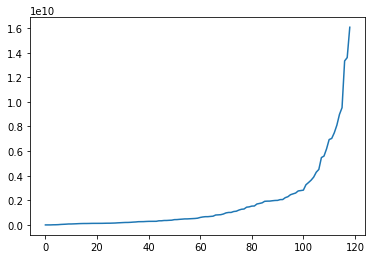

In [464]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(d2.sort_values(by=['counts_intra'])['counts_intra'].tolist())

In [337]:
df = pd.DataFrame({'id': df['id'].tolist(), 'counts_intra': counts_list_intra, 'counts_inter':counts_list_inter })
df.to_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_mouse/stats/mouse_project_contacts_count.txt', index=False, sep='\t')

In [344]:
from os import path
path.exists(input_file)

True

In [80]:
hic_new = hm.hiCMatrix("/grid/gillis/data/lohia/hi_c_data_processing/data_drosophila/aggregates/40kbp_raw/max/hic_gene_intra_KR_ranked.h5")



In [81]:
entire_matrix_intra = hic_new.matrix

In [84]:
entire_matrix_intra.astype('float64')

<15026x15026 sparse matrix of type '<class 'numpy.float64'>'
	with 55820480 stored elements in Compressed Sparse Row format>

In [89]:
entire_matrix_intra[0:1, 0:1] = 0

In [90]:
entire_matrix_intra

<15026x15026 sparse matrix of type '<class 'numpy.float32'>'
	with 55820480 stored elements in Compressed Sparse Row format>

In [517]:
chr_list=["chr3R", "chr3L", "chr2R" , "chr2L" , "chr4" , "chrX"]

In [521]:
chr_list=["chr3L"]

In [526]:
intra_matrix = []
import numpy as np

In [532]:
        for chrom in chr_list: #getting the threshold with only intra-chromosomal contacts
             (start, end) = hic_new.getChrBinRange(chrom)
             z = entire_matrix_intra[start:end, start:end].toarray().flatten()
             thresh_intra = np.percentile(z, 70)
             arr_thresh = np.where(z < thresh_intra, 0, 1)
             print (arr_thresh.sum())
             print (arr_thresh.shape)
             print (np.percentile(z, 70)), print (np.percentile(z, 80)), print (np.percentile(z, 90))
              
                
             intra_matrix.append(entire_matrix_intra[start:end, start:end].toarray().flatten())

        thresh_intra = np.concatenate(intra_matrix, axis=0)

44243052
(147476736,)
0.8087937235832214
0.9003236889839172
0.9615452885627747


In [338]:
reso = 1
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_drosophila/all_proj_agg/aggregate_{reso}kbp_raw.hdf5', 'r') as hfile:
        #print (gene_chrom, var_chrom)
        try:
            #print (hfile[f'/aggregates/{reso}kbp_raw/'].keys())
            net = ss.coo_matrix(
            (hfile[f'/aggregates/{reso}kbp_raw/chr3R_vs_chr3R/data'][:],
             (hfile[f'/aggregates/{reso}kbp_raw/chr3R_vs_chr3R/row'][:],
              hfile[f'/aggregates/{reso}kbp_raw/chr3R_vs_chr3R/col'][:])),
            hfile[f'/aggregates/{reso}kbp_raw/chr3R_vs_chr3R/shape'][:]).tocsr()
        except KeyError:
            net = ss.coo_matrix(
            (hfile[f'/aggregates/1bp_raw/{var_chrom}_vs_chr19/data'][:],
             (hfile[f'/aggregates/1bp_raw/{var_chrom}_vs_chr19/row'][:],
              hfile[f'/aggregates/1bp_raw/{var_chrom}_vs_chr19/col'][:])),
            hfile[f'/aggregates/1bp_raw/{var_chrom}_vs_chr19/shape'][:]).tocsr()
            net = net.T

In [614]:
df

experiment   network    project          run
0   SRX7755137  1kbp_raw  SRP249897  SRR11118383
1   SRX7743243  1kbp_raw  SRP249897  SRR11105815
2   SRX7757436  1kbp_raw  SRP249897  SRR11120501
3   SRX7756045  1kbp_raw  SRP249897  SRR11118813
4   SRX7743501  1kbp_raw  SRP249897  SRR11105557
..         ...       ...        ...          ...
15  SRX8350007  1kbp_raw  SRP261290  SRR11798548
16  SRX8350006  1kbp_raw  SRP261290  SRR11798546
17  SRX8350006  1kbp_raw  SRP261290  SRR11798547
18  SRX8350009  1kbp_raw  SRP261290  SRR11798552
19  SRX8350009  1kbp_raw  SRP261290  SRR11798553

[6733 rows x 4 columns]

In [339]:
res_list_d.append(reso)
z = net.sum(axis=1)
z_list_d.append(z)

In [363]:
reso = 1
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/all_proj_agg/aggregate_{reso}kbp_raw.hdf5', 'r') as hfile:
        #print (gene_chrom, var_chrom)
        try:
            #print (hfile[f'/aggregates/{reso}kbp_raw/'].keys())
            net = ss.coo_matrix(
            (hfile[f'/aggregates/{reso}kbp_raw/chr7_vs_chr7/data'][:],
             (hfile[f'/aggregates/{reso}kbp_raw/chr7_vs_chr7/row'][:],
              hfile[f'/aggregates/{reso}kbp_raw/chr7_vs_chr7/col'][:])),
            hfile[f'/aggregates/{reso}kbp_raw/chr7_vs_chr7/shape'][:]).tocsr()
        except KeyError:
            net = ss.coo_matrix(
            (hfile[f'/aggregates/1bp_raw/{var_chrom}_vs_chr19/data'][:],
             (hfile[f'/aggregates/1bp_raw/{var_chrom}_vs_chr19/row'][:],
              hfile[f'/aggregates/1bp_raw/{var_chrom}_vs_chr19/col'][:])),
            hfile[f'/aggregates/1bp_raw/{var_chrom}_vs_chr19/shape'][:]).tocsr()
            net = net.T



In [325]:
z = net.sum(axis=1)

In [364]:
res_list_h.append(reso)
z = net.sum(axis=1)
z_list_h.append(z)

In [281]:
res_list_2

[40, 25, 10, 5]

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default

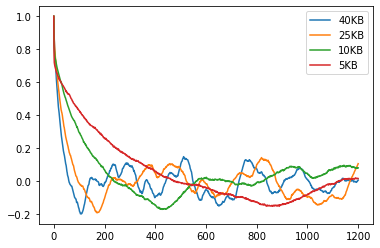

In [313]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(sm.tsa.acf(z_list_2[0], nlags=1200), label='40KB')
plt.plot(sm.tsa.acf(z_list_2[1], nlags=1200), label='25KB')
plt.plot(sm.tsa.acf(z_list_2[2], nlags=1200), label='10KB')
plt.plot(sm.tsa.acf(z_list_2[3], nlags=1200), label='5KB')
plt.legend()

In [615]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler

In [617]:
base_folder="/grid/gillis/data/"

In [618]:
exp_file_path = f'{base_folder}/lohia/hi_c_data_processing/software/CoCoCoNet/networks/drosophila_prioAggNet.h5'

In [716]:
jac_sim_path=f'{base_folder}/lohia/hi_c_data_processing/data_drosophila/ERP016479/1kbp_raw/max/jac_sim/90/all_bins/KR_ranked_KR/hic_gene_corr_gw.h5'


In [707]:
jac_sim = hm.hiCMatrix(jac_sim_path)
exp_file = hm.hiCMatrix(exp_file_path)

In [717]:
given_top_percentile = 1
outfile=f'{base_folder}/lohia/hi_c_data_processing/test.txt'
auc_type = "all"
jac_sim_species='a'
exp_file_species='a'
ortho_genes="ortho_genes"

In [674]:
exp_matrix = exp_file.matrix

In [678]:
j =exp_matrix.astype('float32')

In [679]:
exp_file.setMatrix(j, exp_file.cut_intervals)

In [680]:
exp_file.save('test.h5')

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/tables/atom.py:389: FlavorWarning: support for unicode type is very limited, and only works for strings that can be cast as ascii
  warnings.warn("support for unicode type is very limited, "


In [681]:
il = hm.hiCMatrix('test.h5')

In [682]:
il.matrix

<11508x11508 sparse matrix of type '<class 'numpy.float32'>'
	with 132434064 stored elements in Compressed Sparse Row format>

In [718]:
 
        exp_genes = [x[3].decode() for x in exp_file.cut_intervals]
        exp_matrix = exp_file.matrix.toarray()

        rank_abs = lambda x: stats.rankdata(x, method='ordinal')
        exp_matrix = np.apply_along_axis(rank_abs, 1, exp_matrix)
        
        exp_matrix = exp_matrix * 1.0
        
        exp_matrix = exp_matrix.astype('float32')
        
        
        chr_list_2 = exp_file.getChrNames()

        
        all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
        entire_matrix = jac_sim.matrix.toarray()
        entire_matrix = entire_matrix.astype('float32')
        
        chr_list_1 = jac_sim.getChrNames()

        max_value = entire_matrix.max() + 1 + exp_matrix.max()
        
        max_value = max_value.astype('float32')

        if auc_type == 'inter_only':
        
            for chrom in chr_list_1:

                start, end = jac_sim.getChrBinRange(chrom)
                
                entire_matrix[start: end, start: end] = max_value 
                
            for chrom in chr_list_2:

                start, end = exp_file.getChrBinRange(chrom)
                
                exp_matrix[start: end, start: end] = max_value 
        elif auc_type == 'intra_only':

            coordinate_matrix = np.zeros(entire_matrix.shape,  dtype='float32')
            for chrom in chr_list_1:

                start, end = jac_sim.getChrBinRange(chrom)
                
                coordinate_matrix[start: end, start: end] = max_value
                
            inter_coodinates = np.where(coordinate_matrix != max_value)
            x_inter = inter_coodinates[0].tolist()
            y_inter = inter_coodinates[1].tolist()
            
            entire_matrix[x_inter, y_inter] = max_value
            np.fill_diagonal(entire_matrix , max_value)
            #entire_matrix.setdiag(max_value, k=0)
            
            
            coordinate_matrix = np.zeros(exp_matrix.shape,  dtype='float32')
            for chrom in chr_list_2:

                start, end = exp_file.getChrBinRange(chrom)
                
                coordinate_matrix[start: end, start: end] = max_value
                
            inter_coodinates = np.where(coordinate_matrix != max_value)
            x_inter = inter_coodinates[0].tolist()
            y_inter = inter_coodinates[1].tolist()
            exp_matrix[x_inter, y_inter] = max_value
            np.fill_diagonal(exp_matrix , max_value)
            #exp_matrix.setdiag(max_value, k=0)


        else:

            np.fill_diagonal(entire_matrix , max_value)

            np.fill_diagonal(exp_matrix , max_value)
            #exp_matrix.setdiag(max_value, k=0)
            #entire_matrix.setdiag(max_value, k=0)




In [719]:
        df_jac = pd.DataFrame(entire_matrix ,  index=all_genes, columns = all_genes)
        df_exp = pd.DataFrame(exp_matrix ,  index=exp_genes, columns = exp_genes)

        if jac_sim_species != exp_file_species:
            df_1_1 = pd.read_csv(ortho_genes)
            df_1_1 = df_1_1.drop_duplicates(subset=[jac_sim_species], keep=False)
            df_1_1 = df_1_1.drop_duplicates(subset=[exp_file_species], keep=False)
            jac_sim_species_ortho_subset = list (set(all_genes) & set(df_1_1[jac_sim_species].tolist()))
            df_1_1 = df_1_1[df_1_1[jac_sim_species].isin(jac_sim_species_ortho_subset)]
            exp_file_species_ortho_subset = list (set(exp_genes) & set(df_1_1[exp_file_species].tolist()))
            df_1_1 = df_1_1[df_1_1[exp_file_species].isin(exp_file_species_ortho_subset)]
            subset_genes_exp_file = df_1_1[exp_file_species].tolist()
            subset_genes_jac_sim = df_1_1[jac_sim_species].tolist()
            df_exp_subset = df_exp.loc[subset_genes_exp_file, subset_genes_exp_file]
            df_jac_subset = df_jac.loc[subset_genes_jac_sim, subset_genes_jac_sim]
            
        else:
            subset_genes_exp_file = list (set(all_genes) & set(exp_genes))
            subset_genes_jac_sim  = list (set(all_genes) & set(exp_genes))
            df_exp_subset = df_exp.loc[subset_genes_exp_file, subset_genes_exp_file]
            df_jac_subset = df_jac.loc[subset_genes_jac_sim, subset_genes_jac_sim]




In [721]:
df_exp_subset

FBgn0031251  FBgn0086855  FBgn0034885  FBgn0264574  FBgn0082923  \
FBgn0031251          NaN       1784.0       9724.0       8591.0        142.0   
FBgn0086855       2374.0          NaN       1441.0       6146.0       3453.0   
FBgn0034885      10533.0       1528.0          NaN       6395.0        554.0   
FBgn0264574       4599.0       9431.0       2383.0          NaN        921.0   
FBgn0082923       1670.0       9194.0       1688.0       4940.0          NaN   
...                  ...          ...          ...          ...          ...   
FBgn0086677      10168.0       6031.0       6281.0      10898.0        784.0   
FBgn0039641       2528.0       9245.0       4571.0       5088.0       4438.0   
FBgn0031260       3152.0       9352.0       4440.0       5094.0       3112.0   
FBgn0032522      10238.0       7536.0       2855.0       9419.0        313.0   
FBgn0040964       2980.0      10682.0       1467.0       5987.0       3391.0   

             FBgn0038082  FBgn0034052  FBgn0039601  FBgn0035043  FBgn0031695  \
FBgn0031251       2622.0       1313.0       4214.0       6365.0       7113.0   
FBgn0086855          7.0        848.0      10461.0        348.0       2593.0   
FBgn0034885       8625.0       3458.0       4289.0       8417.0       7788.0   
FBgn0264574        654.0         58.0       8125.0        625.0       3010.0   
FBgn0082923        670.0       2242.0      10193.0        627.0       4814.0   
...                  ...          ...          ...          ...          ...   
FBgn0086677       2176.0        574.0       3329.0       2287.0       8512.0   
FBgn0039641        846.0       3225.0      10767.0       2339.0       3799.0   
FBgn0031260        328.0       2431.0      10721.0       1892.0       1958.0   
FBgn0032522       1277.0       5998.0       5731.0       2502.0       8647.0   
FBgn0040964         10.0        551.0      11050.0        281.0       2567.0   

             ...  FBgn0041188  FBgn0262524  FBgn0050271  FBgn0026372  \
FBgn0031251  ...       8539.0       2338.0      10241.0       1519.0   
FBgn0086855  ...       8477.0       6056.0        844.0       6439.0   
FBgn0034885  ...       7137.0       3021.0       4471.0       9220.0   
FBgn0264574  ...      10929.0       3242.0       2038.0       2848.0   
FBgn0082923  ...       5550.0       3862.0         47.0       8772.0   
...          ...          ...          ...          ...          ...   
FBgn0086677  ...       9936.0        661.0       9658.0       1743.0   
FBgn0039641  ...       5996.0       7569.0         57.0       7933.0   
FBgn0031260  ...       6905.0       6752.0        485.0       9644.0   
FBgn0032522  ...       5886.0       8412.0      11321.0         55.0   
FBgn0040964  ...       6313.0       7688.0        789.0       6331.0   

             FBgn0034214  FBgn0086677  FBgn0039641  FBgn0031260  FBgn0032522  \
FBgn0031251       5418.0      10167.0       1125.0       4059.0       3044.0   
FBgn0086855       9560.0       3500.0       6023.0       7033.0       1715.0   
FBgn0034885       6561.0       6321.0       6817.0       8804.0        660.0   
FBgn0264574       6525.0       8633.0       3354.0       4859.0       1172.0   
FBgn0082923      11379.0       1645.0       9775.0       9318.0        543.0   
...                  ...          ...          ...          ...          ...   
FBgn0086677       6828.0          NaN         81.0        962.0       1564.0   
FBgn0039641      10313.0        111.0          NaN      10082.0        728.0   
FBgn0031260       9236.0        232.0       7405.0          NaN       1197.0   
FBgn0032522       4466.0       5149.0       1546.0       8174.0          NaN   
FBgn0040964       8034.0       2602.0       7330.0       6666.0       2118.0   

             FBgn0040964  
FBgn0031251       2719.0  
FBgn0086855       7958.0  
FBgn0034885       2306.0  
FBgn0264574       6856.0  
FBgn0082923       8606.0  
...                  ...  
FBgn0086677       4416.0  
FBgn0039641       9893.0  
FBgn0031260       6548

In [720]:
        coodinates_1 = np.where(df_jac_subset ==  max_value)
        coodinates_2 = np.where(df_exp_subset ==  max_value)

        x_coo = coodinates_1[0].tolist() + coodinates_2[0].tolist()
        y_coo = coodinates_1[1].tolist() + coodinates_2[1].tolist()

        df_jac_subset.to_numpy()[x_coo, y_coo] = max_value
        df_exp_subset.to_numpy()[x_coo, y_coo] = np.nan

            
        rank_abs = lambda x: stats.rankdata(x)
        predicts2 = np.apply_along_axis(rank_abs, 1, df_jac_subset)
        predicts2 = predicts2.astype('float')
        
        predicts2[x_coo, y_coo] = np.nan
        
        top_percentile = 100 - given_top_percentile
                


In [722]:
        exp_upper = lambda x: np.where(x < np.percentile(x[~np.isnan(x)] , top_percentile), 0, 1.0) if x[~np.isnan(x)].shape[0] > 0 else np.zeros(x.shape[0])
        tp = np.apply_along_axis(exp_upper, 1, df_exp_subset)
        tp[x_coo, y_coo] = np.nan


In [ ]:
tp

In [723]:
        exp_upper = lambda x: np.where(x >= np.percentile(x[~np.isnan(x)] , top_percentile), 0, 1.0) if x[~np.isnan(x)].shape[0] > 0 else np.zeros(x.shape[0])
        tn = np.apply_along_axis(exp_upper, 1, df_exp_subset)
        tn[x_coo, y_coo] = np.nan
        pos_rank_sum = tp * predicts2


In [634]:
tn

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [724]:
auc_array = (((np.nansum(pos_rank_sum, axis=1) / (np.nansum(tp, axis=1)) )- (np.nansum(tp, axis=1) + 1)/2)) / np.nansum(tn, axis=1)
        


In [725]:
np.median(auc_array)

0.5547427760471948

In [ ]:
        df = pd.DataFrame(columns = ['gene_id_jac_sim', 'chrom_jac_sim', 'gene_id_exp_file', 'chrom_exp_file', 'auc'])  
        df['auc'] = auc_array.tolist()
        df['gene_id_exp_file'] = subset_genes_exp_file
        df['gene_id_jac_sim'] = subset_genes_jac_sim
        
        gene_list = [x[3].decode() for x in jac_sim.cut_intervals]
        _chrom_list = [x[0] for x in jac_sim.cut_intervals]
        df['chrom_jac_sim'] = [_chrom_list[gene_list.index(x)] for x in df['gene_id_jac_sim']]

        gene_list = [x[3].decode() for x in exp_file.cut_intervals]
        _chrom_list = [x[0] for x in exp_file.cut_intervals]
        df['chrom_exp_file'] = [_chrom_list[gene_list.index(x)] for x in df['gene_id_exp_file']]
        df.to_csv(outfile, sep='\t', index=False)

In [ ]:
species = "human"
df = df.to_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/stats/{species}_project_contacts_count_inter.txt', sep='\t')